<span style="font-family:Georgia; font-size:25pt">
Model evaluation and hyperparameter tuning
</span>

1. Pipeline
2. Cross-validation
3. Validation curves
4. Grid search
5. Metrics

# Pipeline
Dataset: breast cancer dataset

In [2]:
import pandas as pd
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Columns 3-32[2:] contains 30 real-value features. Columns 2[1] is the class (M: malignant, B: benign).

**LabelEncoder**: Transform the str class to integers.

In [4]:
from sklearn.preprocessing import LabelEncoder 
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [5]:
le.transform(['M','B'])

array([1, 0])

**Split**

In [6]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

/Users/hongsupshin/anaconda/envs/snakes/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Combine transformers and estimators in a pipeline
**Standardize, PCA and logistic regression**

`Pipeline` takes a list of tuples as input. The first element of the tuple is the name of each element for us to get access individial elements.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('scl', StandardScaler()), 
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))
                   ])
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


# k-fold cross-validatioin for model performance

## The holdout method
The right way of using the holdout method is to actually split the entire data into three: **train, validation, and test**. 
1. Train the model with the train set.
2. Select the model with the validation set.
3. Get the final performance estimate with the test set. (no cheating!)

<span class="mark">Disadvantage of the holdeout method</span>
- Model performance is sensitive to how we partition the training set into the training and validation

# k-fold cross-validation
Split the training set into k folds without replacement where (k-1) folds are used for training and one fold is for testing. Repeat this k times and we get k models and their performance estimates.

We use it to find optimal hyperparameters. Then, we **retrain** the model with <span class="mark">the entire training set</span>. Then, we get <span class="mark">a final performance estimate using the independent test set</span>. Also, the estimate performanc is **averaged** estimated performance over all folds.

**Stratified K-fold**: class proportions are preserved and this can be useful for the imbalanced data.

In [8]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold
kfold = StratifiedKFold(y=y_train, n_folds=10, random_state=1)

scores=[]
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train]) # train on the (k-1) folds
    score = pipe_lr.score(X_train[test], y_train[test]) # test on the one fold
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956


In [9]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


**More efficient way of k-fold CV**: <span class="mark">`cross_val_score`</span>
- <span class="mark">`n_jobs`</span>: can use multiple CPUs (if -1, we use all available cores)

In [10]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator = pipe_lr, 
                         X=X_train,
                         y=y_train, 
                         cv=10,
                         n_jobs=1) # uesful feature: we can use multiple processors
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
CV accuracy: 0.950 +/- 0.029


# <span class="mark">Learning and validation curves</span>: debugging algorithms
- Overfitting: model not general enough for new data -> **high variance**
    - How to fix: reduce model complexity (regularization, feature selection, feature extraction), more data
- Underfitting: model performance low -> **high bias**
    - How to fix: increase model complexity
- **Plotting learning and validation curves might be useful for visualization.**
    - learning curves: training and validation accuracy as a function of the <span class="mark">training size</span>
    - validation curves: training and validation accuracy as a function of <span class="mark">model parameter values</span>

## Learning curves: <span class="mark">bias and variance diagnosis</span>

In [11]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set('poster')
sns.set_style('whitegrid')

plt.style.use = 'default'
new_style = {'grid': False}
matplotlib.rc('axes', **new_style)

In [12]:
from sklearn.learning_curve import learning_curve
pipe_lr = Pipeline([
        ('scl', StandardScaler()),
        ('clf', LogisticRegression(penalty='l2', random_state=0))])

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)

/Users/hongsupshin/anaconda/envs/snakes/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


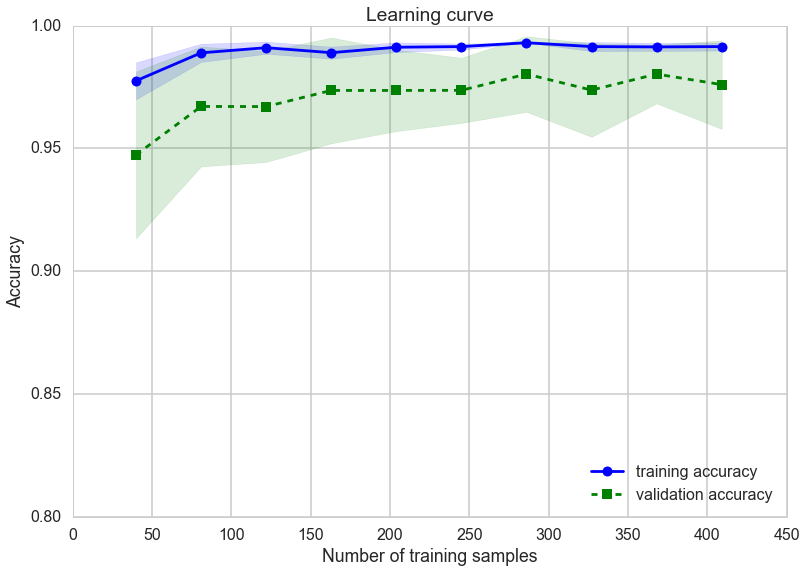

In [13]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=10, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=10, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.title('Learning curve')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

## Validation curve: <span class="mark">address overfitting and underfitting</span>
In this example, we evaluate the performance across different parameter values of logistic regression.

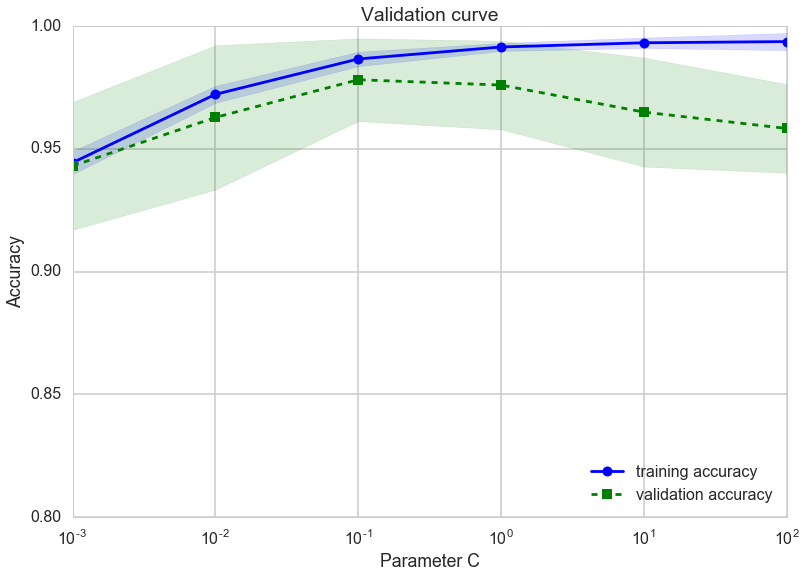

In [14]:
from sklearn.learning_curve import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                               X=X_train,
                                               y=y_train,
                                               param_name='clf__C',
                                               param_range=param_range,
                                               cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=10, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=10, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.title('Validation curve')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')

plt.ylim([0.8, 1.0])
plt.show()

As we increase C (inverse of regularization parameter lambda), we see the training performance gets better, which suggests overfitting. However, if we lower the C (stronger regularization), model performance drops slightly. The author suggests the sweet spot might be around C = 0.1

# Grid search: hyperparameter tuning
`GridSearhCV` requires parameter grid (`param_grid`).
- A list of dictionaries to specify the parameters we'd want to tune.
- Example below:
    - linear SVM: C 
    - RBF kernel SVM: C and gamma

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = Pipeline([('scl',StandardScaler()),
                     ('clf',SVC(random_state=1))])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range,
               'clf__kernel': ['linear']},
              {'clf__C': param_range,
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.978021978022
{'clf__kernel': 'linear', 'clf__C': 0.1}


Finally, we use the independent test dataset to estimate the performance of the best selected model (`best_estimator_`). Don't forget to retrain the model with the entire data.

In [25]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


Grid search is an exhaustive search, which is usually computationally challengeing and might not be a feasible option. sklearn provides alternatives like a <span class="mark">randomized search</span>. There are some reports saying that the randomized search is faster and still provides a similar level of performance results.

## <span class="mark">Nested</span> cross-validation
Useful for seleting a model among different ML algorithms. This is different from k-fold CV. Studies found the true error of the estimate is almost unbiased relative to the test set with nested CV.

**How it works**
- There's an **outer k-fold CV loop** to split the data into training and test folds.
- There's an **inner loop** that is used to select the model using k-fold CV on the training fold.
    - Meaning, the training fold of each k-fold split (k-1 folds) is split into training and validation fold.

Useful for **large data sets** where **performance is important**. Example: **5x2** CV (5: outer, 2: inner).

In [26]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2, # inner loop
                  n_jobs=-1)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.965 +/- 0.025


One important point here: after constructing gs, <span class="mark">we do not fit the gs to the training data</span> like we did previously: `gs = gs.fit(X_train, y_train)`. Instead, we fid our gs to `cross_val_score`.

In [32]:
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth':[1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.921 +/- 0.029


# Metrics
## Confusion matrix
- In the sklearn `confusion_matrix`, in binary classification, 
    - true negatives is `C_{0,0}`
    - false negatives is `C_{1,0}`
    - true positives is `C_{1,1}`
    - false positives is `C_{0,1}`.

<span class="mark">So, x (columns) axis is predicted, y (rows) axis is true.</span>

In [33]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


We can visualize this by using matplotlib <span class="mark">`matshow` function.</span>

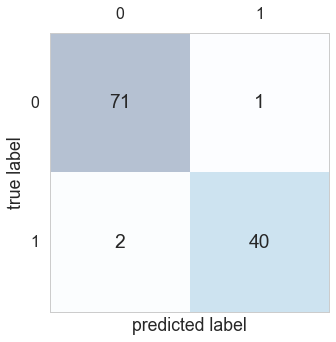

In [35]:
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3) #Plot a matrix or array as an image.
for i in range(confmat.shape[0]): # rows
    for j in range(confmat.shape[1]): # columns
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')        
plt.ylabel('true label')        
plt.show()

## Precision and recall
Usual default metrics
- Error: (FN + FP) / All
- Accuracy: (TN + TP) / All

True and false positive ratios: useful for **imbalanced data**
- True positive rate (TPR): proportion of true positives over all positive samples
    - TP / (FN + TP)
- False positive rate (FPR): proportion of false positives over all negative samples
    - FP / (FP + TN)

Precision and recall
- Recall = true positive rate = sensitivity
- Precision: proportion of true positives among all samples predicted as positives
- F1: harmonic mean of recall and precision (2 x pre x rec / (pre + rec))

Sensitivity and specificity
- Sensitivity = recall = TPR
- Specificity = true negative rate

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


We can use different score metrics for the grid search in sklearn.

One more thing, in sklearn, <span class="mark">positive classes are labeld as 1.</span> If we want to specify a different positive label, we can use `make_scorer`.

In [39]:
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10)

We can use <span class="mark">`precision_recall_curve`</span> to visualize the results.

## ROC (receiver operating characterstic) curves
- Useful for **selecting models** based on their <span class="mark">performance wrt the false positive and true positve rates</span>.
- Diagonal line: random guesses
- Perfect classifier: top-left corner of the graph (TPR = 1, FPR = 0): this means <span class="mark">x axis: FPR, y axis: TPR</span>.
- area under the curve (AUC) can address model performance as well.

<span class="mark">sklearn `roc_curve`</span>
- y_true: True binary labels (otherwise, specifised with `pos_label`)
- y_score: Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of decisions (as returned by "decision_function" on some classifiers) 
- return `thresholds`: Decreasing thresholds on the decision function used to compute fpr and tpr.

**scipy `interp(x, xp, fp)`**
- One-dimensional linear interpolation.
- x : The x-coordinates of the interpolated values.
- xp : The x-coordinates of the **data points**, must be **increasing**
- fp : The y-coordinates of the **data points**

In [41]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2', random_state=0, C=100.0))])

# making the problem more challenging intensionally so that we can see the difference in ROC curves (here we only select 2 features)
X_train2 = X_train[:, [4, 14]]
cv = StratifiedKFold(y_train, n_folds=3, random_state=1) # again, only 3 folds

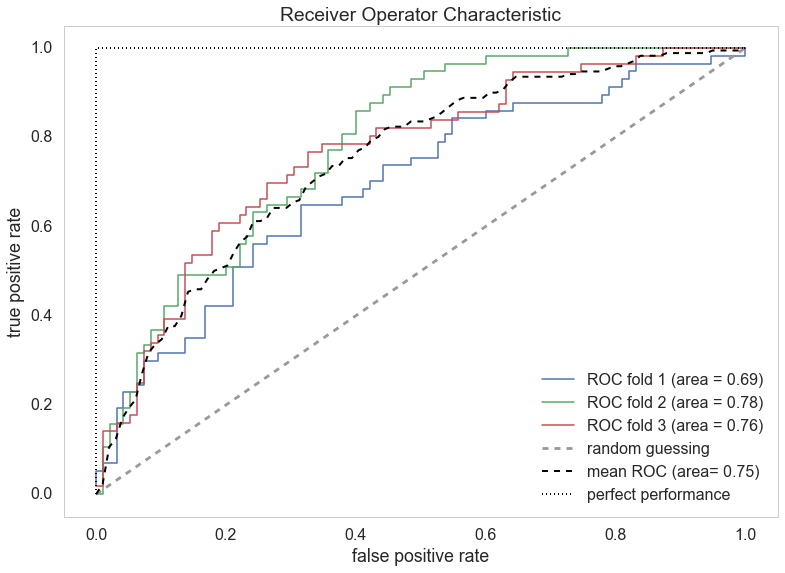

In [70]:
fig = plt.figure()
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_true = y_train[test], y_score = probas[:, 1], pos_label=1)
    
    mean_tpr += interp(mean_fpr, fpr, tpr) # mean tpr is interporlated based on roc curve values
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=1.5, label='ROC fold %d (area = %.2f)' % (i+1, roc_auc))
    
plt.plot([0,1],[0,1],linestyle='--',color=(.6,.6,.6), label='random guessing')    

# compute the average across all folds
mean_tpr /= len(cv) # normalize to 1 (same as mean_tpr = mean_tpr / len(cv))
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--', label='mean ROC (area= %.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc='lower right')
plt.show()

Here, we computed mean ROC curve by using interpolation. Note that in each fold in the loop, we interpolated based on the true ROC curve and summed them and later we normalized by dividing the value by `len(cv)`. This is because `fpr` and `trp` from `roc_curve` do <span class="mark">not have equal and uniform bins.</span>

We can also directly calculate AUC.

In [76]:
from sklearn.metrics import roc_auc_score, accuracy_score
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:, [4, 14]])
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

ROC AUC: 0.662
Accuracy: 0.711


<span class="mark">Reporting ROC AUC can give insights on imbalanced samples</span>. Althought accuracy score is a single point on a ROC curve, ROC AUC and accuracy generalty agree with each other.

However, reporting ROC AUC (as a single number) seems counterintuitive because the whole point of ROC curve is to show a trade-off between different model settings. [A Wikepedia article](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) shows a criticism on ROC AUC regarding this aspect.

## Metrics for multi-class classification
sklearn has **macro** and **micro** averaging methods via **One vs. All** (OvA or OvR) classification.
- micro: calculated from individual TP, TN, FP, FN of the system.
    - useful if we weight **each instance equally**
- macro: calculated as average scores of the different systems.
    - useful if evaluate the overall performance wrt the **most frequent class labels**
- for a binary clf, *weighted* macro is default.
    - weighting the score of each class based on class sample size. Thus, **useful for class imbalance**.
    
To specify the average method:    

In [77]:
pre_scorer = make_scorer(score_func=precision_score,
                         pos_label=1,
                         # Whether score_func is a score function (default), meaning high is good, or a loss function, meaning low is good.
                         greater_is_better=True, 
                         average='micro')